# Milestone Project 1 : Food vision big 🍔👁

## Check GPU

Google Colab offers free GPUs, however not all of them are compatiable with mixed precision training.

Google Colab offers:
* K80 (not compatiable)
* P100 (not compatiable)
* Tesla T4 (compatiable)

When using mixed precision, we need a gpu with compute capability above 7.0
https://developer.nvidia.com/cuda-gpus

In [ ]:
# check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-26b367f7-05f8-31aa-0829-e47190c25c89)


In [ ]:
# downgrade the tensorflow version because the EfficientNetB0 is running error when using mixed precision
!pip install tensorflow==2.4.1  

     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 3.8 MB 59.0 MB/s 
     |████████████████████████████████| 2.9 MB 43.8 MB/s 
     |████████████████████████████████| 462 kB 51.4 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.

## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learning/main/Utils/helper_functions.py

--2021-08-12 15:33:16--  https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learning/main/Utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10452 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.21K  --.-KB/s    in 0s      

2021-08-12 15:33:16 (97.5 MB/s) - ‘helper_functions.py’ saved [10452/10452]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download data

Read the guide: https://www.tensorflow.org/datasets

In [ ]:
# Get TensorFlow Dataset
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets 
datasets_list = tfds.list_builders()
print("food101" in datasets_list) # check if food101 ds is in dslist

True


In [ ]:
# load in the data (takes 5-6 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False, # for validation metrics 
                                             as_supervised=True, # Get the data in tuples (features, labels)
                                             with_info=True) # return info in ds_info variables

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteE3P7M5/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteE3P7M5/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 from tfds

To become one with the data, we want to find:
* class names
* the shape of our input data (image tensor)
* the datatype of our input data
* what the labels look like (e.g they're hotcode or label encoded).
* Do the label math up with the class name.

In [ ]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train_data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# output info about our training sample
for image, label in train_one_sample:
  print(f"""
    Image shape: {image.shape},
    Image datatype: {image.dtype},
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
  """)


    Image shape: (384, 512, 3),
    Image datatype: <dtype: 'uint8'>,
    Target class from Food101 (tensor form): 97
    Class name (str form): takoyaki
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[104, 125, 120],
        [ 99, 118, 114],
        [ 24,  39,  36],
        ...,
        [113,  49,  24],
        [104,  40,  15],
        [114,  50,  25]],

       [[109, 128, 124],
        [111, 130, 126],
        [ 53,  65,  63],
        ...,
        [112,  48,  23],
        [107,  43,  18],
        [113,  49,  24]],

       [[114, 130, 127],
        [119, 135, 132],
        [ 79,  89,  88],
        ...,
        [110,  46,  19],
        [108,  44,  17],
        [109,  45,  18]],

       ...,

       [[230, 146,  58],
        [241, 157,  69],
        [244, 160,  70],
        ...,
        [149,  90,  22],
        [166, 103,  34],
        [203, 138,  70]],

       [[230, 146,  58],
        [245, 161,  73],
        [250, 166,  76],
        ...,
        [166, 107,  39],
        [177, 112,  44],
        [223, 156,  86]],

       [[227, 143,  55],
        [247, 163,  75],
        [255, 171,  81],
        ...,
        [172, 113,  4

In [ ]:
# What are the min and the max value in the image tensor
import tensorflow as tf

tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=0>)

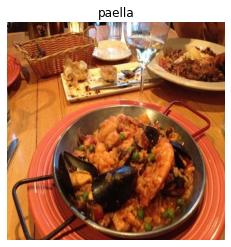

In [ ]:
## Plot a image from Tensorflow Datasets
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)
plt.show()

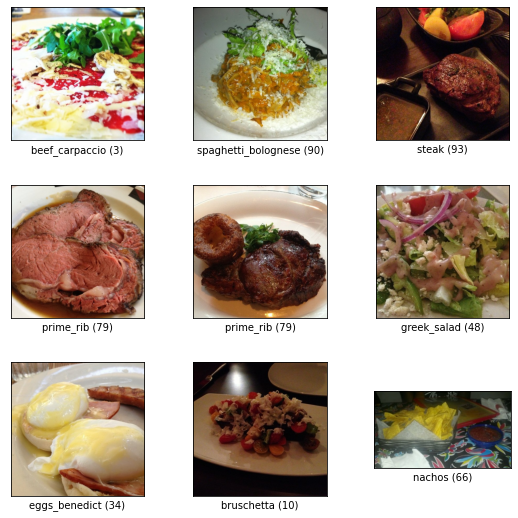

In [ ]:
import matplotlib.pyplot as plt

fig = tfds.show_examples(train_data, ds_info)

## Create preprocessing functions for our data

Neural network perform best when data in a certain way (e.g batched, normalized, etc).

However, not all data, including data come tfds comes like this.

So in order to get it ready for ANN, you'll often have to write preprocessing functions and map it to your data.

What we know about data:
* In `uint8` datatype.
* Comprised of all different size tensors (different size images).
* Not scaled (value still in between 0 to 255).

What we know model likes:
* Data in `float32` dtype (or mixed precision `float16` and `float32`).
* For batches, tensorflow likes all of the tensor within a batch to be of the same size.
* Scaled (value between 0 and 1) also called normalized tensor generally perform better.

With these points in mind, we got a few thing we can tackle with a preprocessing function.

Since we're going to be using EfficientNetBx pretrained model from `tf.keras.applications` we don't need to rescale our data (these architecture have rescaling built-in).

This means our function needs to:
1. Reshape our images to all the same size.
2. Convert the dtype of our images from `unint8` to `float32`.

In [ ]:
# (image, label)

In [ ]:
def preprocess_image(image, label, rescale=False, img_shape=224):
  """
  Converts image datatype from 'unint8' -> 'float32' and reshapes
  images to (img_shape, image_shape, 3)
  rescale to range 0-1 if rescale = True
  """
  img = tf.image.resize(image, size=[img_shape, img_shape])
  if rescale:
    return tf.cast(img, dtype=tf.float32)/255., label
  return tf.cast(img, dtype=tf.float32), label # return (float32_image, label) tuple

In [ ]:
preprocessed_img = preprocess_image(image, label)[0]
print(f"Image before processing:\n {image[:2]}..., \n shape: {image.shape}, dtype {image.dtype}")
print(f"Image after  processing:\n {preprocessed_img[:2]}..., \n shape: {preprocessed_img.shape}, dtype {preprocessed_img.dtype}")

Image before processing:
 [[[104 125 120]
  [ 99 118 114]
  [ 24  39  36]
  ...
  [113  49  24]
  [104  40  15]
  [114  50  25]]

 [[109 128 124]
  [111 130 126]
  [ 53  65  63]
  ...
  [112  48  23]
  [107  43  18]
  [113  49  24]]]..., 
 shape: (512, 512, 3), dtype <dtype: 'uint8'>
Image after  processing:
 [[[106.89285  126.147964 122.02041 ]
  [  4.239786  12.137741  11.040804]
  [ 10.076534  11.918371  15.637758]
  ...
  [107.305984  43.30598   16.305983]
  [116.99993   52.999935  27.999935]
  [108.581894  44.58189   19.581892]]

 [[119.13776  132.41837  130.0153  ]
  [ 24.545902  29.239775  29.964268]
  [ 15.612247  13.158165  16.285715]
  ...
  [110.13274   46.132732  19.132734]
  [109.137726  45.137726  18.137728]
  [107.03052   43.030518  16.030518]]]..., 
 shape: (224, 224, 3), dtype <dtype: 'float32'>


## Batch and prepare datasets

We're now going to make our data input pipeline run really fast.

Read the document here: https://www.tensorflow.org/guide/data_performance

In [ ]:
import tensorflow as tf

In [ ]:
# Map preprocessing function to training and (parallelize)
train_data_optimized = train_data.map(map_func=preprocess_image,
                               num_parallel_calls=tf.data.AUTOTUNE) # states that please run as much as you can 

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data_optimized = train_data_optimized.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to testing and (parallelize)
test_data_optimized = test_data.map(map_func=preprocess_image,
                          num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data_optimized, test_data_optimized

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow, map this preprocessing function `preprocess_img()` across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (find patterns) the current batch"

## Create modelling callbacks

In [ ]:
import tensorflow as tf


checkpoint_path = "Food101_checkpoint/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         save_freq='epoch',
                                                         verbose=0)

tensorboard_callback = create_tensorboard_callback(dir_name="training_logs",
                                                   experiment_name="efficientnetb0_101_classes_all_data_feature_extract")

# earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
#                                                           patience=2)

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20210812-125107


## Setting the mixed precision

Speed up training time 😎😎😎

Read the document: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [ ]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')

tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
tf.__version__

'2.4.1'

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=(224,224,3), name="input_layer")

# Create rescaling layers if base_model doen't not have built-in
# x = preprocessing.Rescaling(scale=1./255)(inputs)

# Stack the base_model
x = base_model(inputs, training=False) # Make sure layers which should not be inference mode 
# Create functional layer
x = layers.GlobalAveragePooling2D(name="global_average_pool_2D")(x)

# Create ouput layer
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),# because the labels are in int form not one-hot
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool_2D (Glob (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes at each layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_layer True <Policy "float32">
efficientnetb0 False <Policy "mixed_float16">
global_average_pool_2D True <Policy "mixed_float16">
dense_1 True <Policy "mixed_float16">
softmax_float32 True <Policy "float32">


In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_2 False <Policy "float32">
rescaling_1 False <Policy "mixed_float16">
normalization_1 False <Policy "float32">
stem_conv_pad False <Policy "mixed_float16">
stem_conv False <Policy "mixed_float16">
stem_bn False <Policy "mixed_float16">
stem_activation False <Policy "mixed_float16">
block1a_dwconv False <Policy "mixed_float16">
block1a_bn False <Policy "mixed_float16">
block1a_activation False <Policy "mixed_float16">
block1a_se_squeeze False <Policy "mixed_float16">
block1a_se_reshape False <Policy "mixed_float16">
block1a_se_reduce False <Policy "mixed_float16">
block1a_se_expand False <Policy "mixed_float16">
block1a_se_excite False <Policy "mixed_float16">
block1a_project_conv False <Policy "mixed_float16">
block1a_project_bn False <Policy "mixed_float16">
block2a_expand_conv False <Policy "mixed_float16">
block2a_expand_bn False <Policy "mixed_float16">
block2a_expand_activation False <Policy "mixed_float16">
block2a_dwconv_pad False <Policy "mixed_float16">
block2a_dwconv Fa

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general oder of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen).
2. Fine-tune some of the frozen layers.

In [ ]:
# Fit the feature extraction model with mixed precision 
history_101_food_classes_feature_extraction = model.fit(train_data_optimized,
                                                        epochs=3,
                                                        steps_per_epoch=len(train_data_optimized),
                                                        validation_data=test_data_optimized,
                                                        validation_steps=int(0.15 * len(test_data_optimized)),
                                                        callbacks=[tensorboard_callback,
                                                                   checkpoint_callback])

Epoch 1/3
2368/2368 [==============================] - 178s 72ms/step - loss: 2.3437 - accuracy: 0.4629 - val_loss: 1.2241 - val_accuracy: 0.6803
Epoch 2/3
2368/2368 [==============================] - 167s 70ms/step - loss: 1.3202 - accuracy: 0.6615 - val_loss: 1.1329 - val_accuracy: 0.6949
Epoch 3/3
2368/2368 [==============================] - 168s 70ms/step - loss: 1.1502 - accuracy: 0.7033 - val_loss: 1.0877 - val_accuracy: 0.7082


In [ ]:
# Map prepreprocessing function to test data
test_data_optimized = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data_optimized = test_data_optimized.batch(32).prefetch(tf.data.AUTOTUNE)

## Nearly crash the colab because of out of ram 

In [ ]:
# Evaluate the model on the whole test data
results_feature_extract = model.evaluate(test_data_optimized)
results_feature_extract

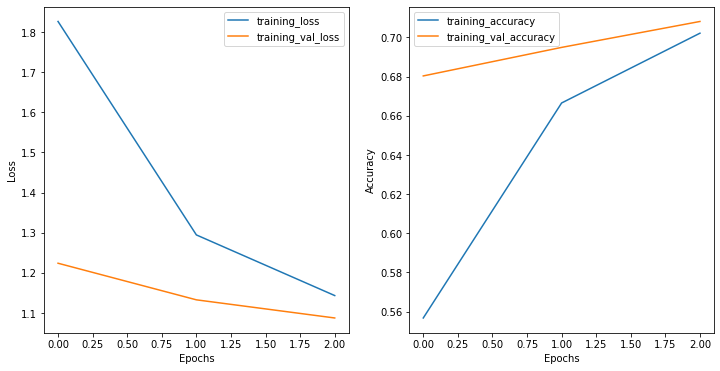

In [ ]:
plot_loss_curves(history_101_food_classes_feature_extraction)

In [ ]:
import pickle

with open('/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/feature_extract_history', 'wb') as file_pi:
  pickle.dump(history_101_food_classes_feature_extraction.history, file_pi)

In [ ]:
# Save the model to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/101_classes_full_data_feature_extraction.h5')

# Off to you

Challenge: train a model to beat the paper accuracy: https://arxiv.org/ftp/arxiv/papers/1606/1606.05675.pdf

## Fine-tuning last 10 layers?

Learning_rate = 0.0001

In [ ]:
initial_epochs = 3
# train fine-tuning for more 10 epochs
fine_tuning_epochs = initial_epochs + 10

In [ ]:
# Load checkpoint
model.load_weights(file_path)
model.evaluate(test_data_optimized)

790/790 [==============================] - 50s 62ms/step - loss: 1.0871 - accuracy: 0.7080


[1.0871047973632812, 0.7079603672027588]

In [ ]:
# Unfreeze all layer in the base_model
base_model.trainable = True

# Freeze all layer but last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
# Compile the model again 
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_1 False <Policy "float32">
rescaling False <Policy "mixed_float16">
normalization False <Policy "float32">
stem_conv_pad False <Policy "mixed_float16">
stem_conv False <Policy "mixed_float16">
stem_bn False <Policy "mixed_float16">
stem_activation False <Policy "mixed_float16">
block1a_dwconv False <Policy "mixed_float16">
block1a_bn False <Policy "mixed_float16">
block1a_activation False <Policy "mixed_float16">
block1a_se_squeeze False <Policy "mixed_float16">
block1a_se_reshape False <Policy "mixed_float16">
block1a_se_reduce False <Policy "mixed_float16">
block1a_se_expand False <Policy "mixed_float16">
block1a_se_excite False <Policy "mixed_float16">
block1a_project_conv False <Policy "mixed_float16">
block1a_project_bn False <Policy "mixed_float16">
block2a_expand_conv False <Policy "mixed_float16">
block2a_expand_bn False <Policy "mixed_float16">
block2a_expand_activation False <Policy "mixed_float16">
block2a_dwconv_pad False <Policy "mixed_float16">
block2a_dwconv False 

In [ ]:
# Setup callbacks
fine_tuning_checkpoint_path = "Food101_fine_tune_checkpoint/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=fine_tuning_checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         save_freq="epoch")

# tensorboard_callback = create_tensorboard_callback(dir_name="training_logs",
#                                                    experiment_name="efficientnetb0_101_classes_all_data_fine_tune")

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                          patience=3)

In [ ]:
initial_epochs = 3
# train fine-tuning for more 10 epochs
fine_tuning_epochs = initial_epochs + 10

In [ ]:
# Fine tune for more 10 epochs
history_101_food_classes_fine_tune_10_layers = model.fit(train_data_optimized,
                                                               epochs=fine_tuning_epochs,
                                                               initial_epoch=history_101_food_classes_feature_extraction.epoch[-1],
                                                               steps_per_epoch=len(train_data_optimized),
                                                              validation_data=test_data_optimized,
                                                              validation_steps=int(0.15 * len(test_data_optimized)),
                                                              callbacks=[checkpoint_callback,earlystopping_callback])

Epoch 3/13
2368/2368 [==============================] - 213s 84ms/step - loss: 0.9873 - accuracy: 0.7391 - val_loss: 0.9708 - val_accuracy: 0.7344
Epoch 4/13
2368/2368 [==============================] - 196s 80ms/step - loss: 0.8141 - accuracy: 0.7848 - val_loss: 0.9592 - val_accuracy: 0.7386
Epoch 5/13
2368/2368 [==============================] - 200s 80ms/step - loss: 0.6821 - accuracy: 0.8199 - val_loss: 0.9596 - val_accuracy: 0.7386
Epoch 6/13
2368/2368 [==============================] - 189s 79ms/step - loss: 0.5931 - accuracy: 0.8441 - val_loss: 0.9801 - val_accuracy: 0.7436
Epoch 7/13
2368/2368 [==============================] - 211s 85ms/step - loss: 0.5128 - accuracy: 0.8684 - val_loss: 0.9903 - val_accuracy: 0.7362
Epoch 8/13
2368/2368 [==============================] - 206s 83ms/step - loss: 0.4383 - accuracy: 0.8894 - val_loss: 1.0034 - val_accuracy: 0.7442
Epoch 9/13
2368/2368 [==============================] - 206s 83ms/step - loss: 0.3708 - accuracy: 0.9096 - val_loss: 1

In [ ]:
model.evaluate(test_data_optimized)

790/790 [==============================] - 56s 71ms/step - loss: 1.0799 - accuracy: 0.7334


[1.0798733234405518, 0.7333861589431763]

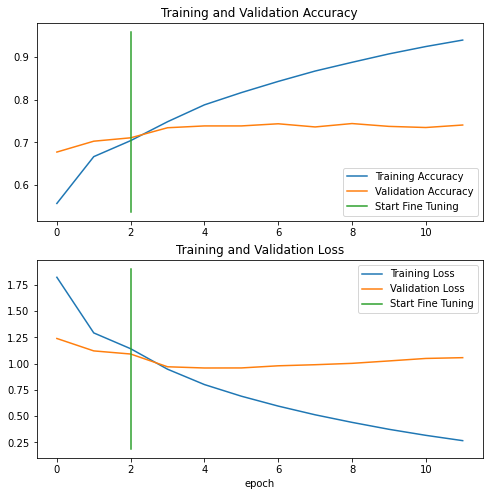

In [ ]:
compare_historys(history_101_food_classes_feature_extraction, history_101_food_classes_fine_tune_10_layers, initial_epochs=3)

## Continue Fine-tuning more 10 last layers (last 20 layers)

This time, we'll start to fine tuning next 10 layers

In [ ]:
load_checkpoint_path = "/content/Food101_fine_tune_checkpoint/checkpoint.ckpt"

model.load_weights(load_checkpoint_path)

In [ ]:
model.evaluate(test_data_optimized)

790/790 [==============================] - 63s 73ms/step - loss: 1.0062 - accuracy: 0.7371


[1.0062282085418701, 0.7371485233306885]

In [ ]:
# Unfreeze all layer in the base_model
base_model.trainable = True

# Freeze all layer but last 20 layers
for layer in base_model.layers[:-20]:
  layer.trainable = False

In [ ]:
# Compile the model again 
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=["accuracy"]
)

In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

input_1 False <Policy "float32">
rescaling False <Policy "mixed_float16">
normalization False <Policy "float32">
stem_conv_pad False <Policy "mixed_float16">
stem_conv False <Policy "mixed_float16">
stem_bn False <Policy "mixed_float16">
stem_activation False <Policy "mixed_float16">
block1a_dwconv False <Policy "mixed_float16">
block1a_bn False <Policy "mixed_float16">
block1a_activation False <Policy "mixed_float16">
block1a_se_squeeze False <Policy "mixed_float16">
block1a_se_reshape False <Policy "mixed_float16">
block1a_se_reduce False <Policy "mixed_float16">
block1a_se_expand False <Policy "mixed_float16">
block1a_se_excite False <Policy "mixed_float16">
block1a_project_conv False <Policy "mixed_float16">
block1a_project_bn False <Policy "mixed_float16">
block2a_expand_conv False <Policy "mixed_float16">
block2a_expand_bn False <Policy "mixed_float16">
block2a_expand_activation False <Policy "mixed_float16">
block2a_dwconv_pad False <Policy "mixed_float16">
block2a_dwconv False 

In [ ]:
# Setup callbacks
fine_tuning_checkpoint_path = "Food101_fine_tune_checkpoint_20_layers/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=fine_tuning_checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         save_freq="epoch")

# tensorboard_callback = create_tensorboard_callback(dir_name="training_logs",
#                                                    experiment_name="efficientnetb0_101_classes_all_data_fine_tune")

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                          patience=3)

In [ ]:
history_101_food_classes_fine_tune_10_layers.epoch

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [ ]:
initial_epochs = history_101_food_classes_fine_tune_10_layers.epoch[-1]
# train fine-tuning for more 10 epochs
fine_tuning_epochs = initial_epochs + 10

# Fine tune for more 10 epochs
history_101_food_classes_fine_tune_20_layers = model.fit(train_data_optimized,
                                                               epochs=fine_tuning_epochs,
                                                               initial_epoch=history_101_food_classes_fine_tune_10_layers.epoch[-1],
                                                               steps_per_epoch=len(train_data_optimized),
                                                              validation_data=test_data_optimized,
                                                              validation_steps=int(0.15 * len(test_data_optimized)),
                                                              callbacks=[checkpoint_callback,earlystopping_callback])

Epoch 11/20
2368/2368 [==============================] - 217s 85ms/step - loss: 0.3315 - accuracy: 0.9255 - val_loss: 1.0349 - val_accuracy: 0.7466
Epoch 12/20
2368/2368 [==============================] - 197s 82ms/step - loss: 0.2900 - accuracy: 0.9343 - val_loss: 1.0332 - val_accuracy: 0.7463
Epoch 13/20
2368/2368 [==============================] - 196s 81ms/step - loss: 0.2708 - accuracy: 0.9403 - val_loss: 1.0706 - val_accuracy: 0.7423
Epoch 14/20
2368/2368 [==============================] - 199s 83ms/step - loss: 0.2511 - accuracy: 0.9458 - val_loss: 1.0923 - val_accuracy: 0.7450


In [ ]:
results_fine_tune_20_layers = model.evaluate(test_data_optimized)
results_fine_tune_20_layers

790/790 [==============================] - 56s 71ms/step - loss: 1.0976 - accuracy: 0.7385


[1.0976098775863647, 0.7385346293449402]

## Experiment that success

In [ ]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

# from helper_functions import unzip_data

# unzip_data("07_efficientnetb0_feature_extract_model_mixed_precision.zip")

# loaded_model = tf.keras.models.load_model("07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# loaded_model.evaluate(test_data_optimized)

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/101_classes_full_data_feature_extraction.h5")

In [ ]:
loaded_model.evaluate(test_data_optimized)

In [ ]:
loaded_model.summary()

In [ ]:
for layer in loaded_model.layers:
  print(layer.name, layer.trainable)

In [ ]:
# Un freeze all layers in the base model EfficientNetB0
base_model = loaded_model.layers[1]

base_model.trainable = True

In [ ]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

In [ ]:
loaded_model.summary()

In [ ]:
# Create call back
checkpoint_path = "Food101_fine_tuning_checkpoint/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         monitor="val_accuracy",
                                                         save_best_only=True,
                                                         save_weights_only=True)

earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                          patience=5)

In [ ]:
# Re-compile the model
loaded_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [ ]:
initial_epochs = 3
# Define fine tune epochs
fine_tune_epochs = 100 + initial_epochs

In [ ]:
history_fine_tuning_all_layers = loaded_model.fit(train_data_optimized,
                                                  epochs=100,
                                                  initial_epoch=intial_epochs,
                                                  steps_per_epoch=len(train_data_optimized),
                                                  validation_data=test_data_optimized,
                                                  validation_steps=int(0.15 * len(test_data_optimized)),
                                                  callbacks=[checkpoint_callback,
                                                             earlystopping_callback])

In [ ]:
results_fine_tune = loaded_model.evaluate(test_data_optimized)
results_fine_tune

In [ ]:
loaded_model.save("/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/101_classes_full_data_fine_tuning_2.h5")

In [ ]:
from helper_functions import compare_historys

In [ ]:
compare_historys(history_101_food_classes_feature_extraction, history_fine_tuning_all_layers, initial_epochs=3b)

### Testing and visualizing 

In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Tensorflow Certificate Exam/Weights/101_classes_full_data_fine_tuning_2.h5")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
loaded_model.evaluate(test_data_optimized)

790/790 [==============================] - 84s 63ms/step - loss: 1.2311 - accuracy: 0.7716


[1.2310680150985718, 0.7716435790061951]

In [ ]:
# Map preprocessing function to testing and (parallelize) - > disable shuffle for validation
test_data_optimized = test_data.map(map_func=preprocess_image,
                          num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
y_preds = loaded_model.predict(test_data_optimized)

In [ ]:
import numpy as np

y_preds = np.array(tf.argmax(y_preds, axis = 1))

In [ ]:
labels = []
for img, label in test_data_optimized.unbatch():
  labels.append(label.numpy())

In [ ]:
y_true = np.array(labels)
y_preds.shape, y_true.shape

((25250,), (25250,))

In [ ]:
np.array(y_preds[50:100])

array([ 22,  40,  60,  13,  56,  52,  21,  25,  29,  64,  66,  81,   1,
        52,  83,  16,  60,  32,  36,  94,  48,  45,  65,  29,   9,  93,
        87,  65,  64,  37,   1,  75,  61,  74,  54,  76,  82,  90,  15,
         4,  15,  19,  49, 100,  93,  62,  37,  99,  40,  60])

In [ ]:
np.array(y_true[50:100])

array([ 98,  40,  60,  13,  36,  92,  21,  25,  29,  81,  66,  81,   1,
        92,  83,  16,  60,  32,  36,  94,  48,   0,  65,  29,  56,  37,
        87,  65,  64,  26,   1,  75,  61,  74,  54,  76,  34,  90,  15,
         4,  15,  19,  49, 100,  93,  62,  37,  99,  40,  60])

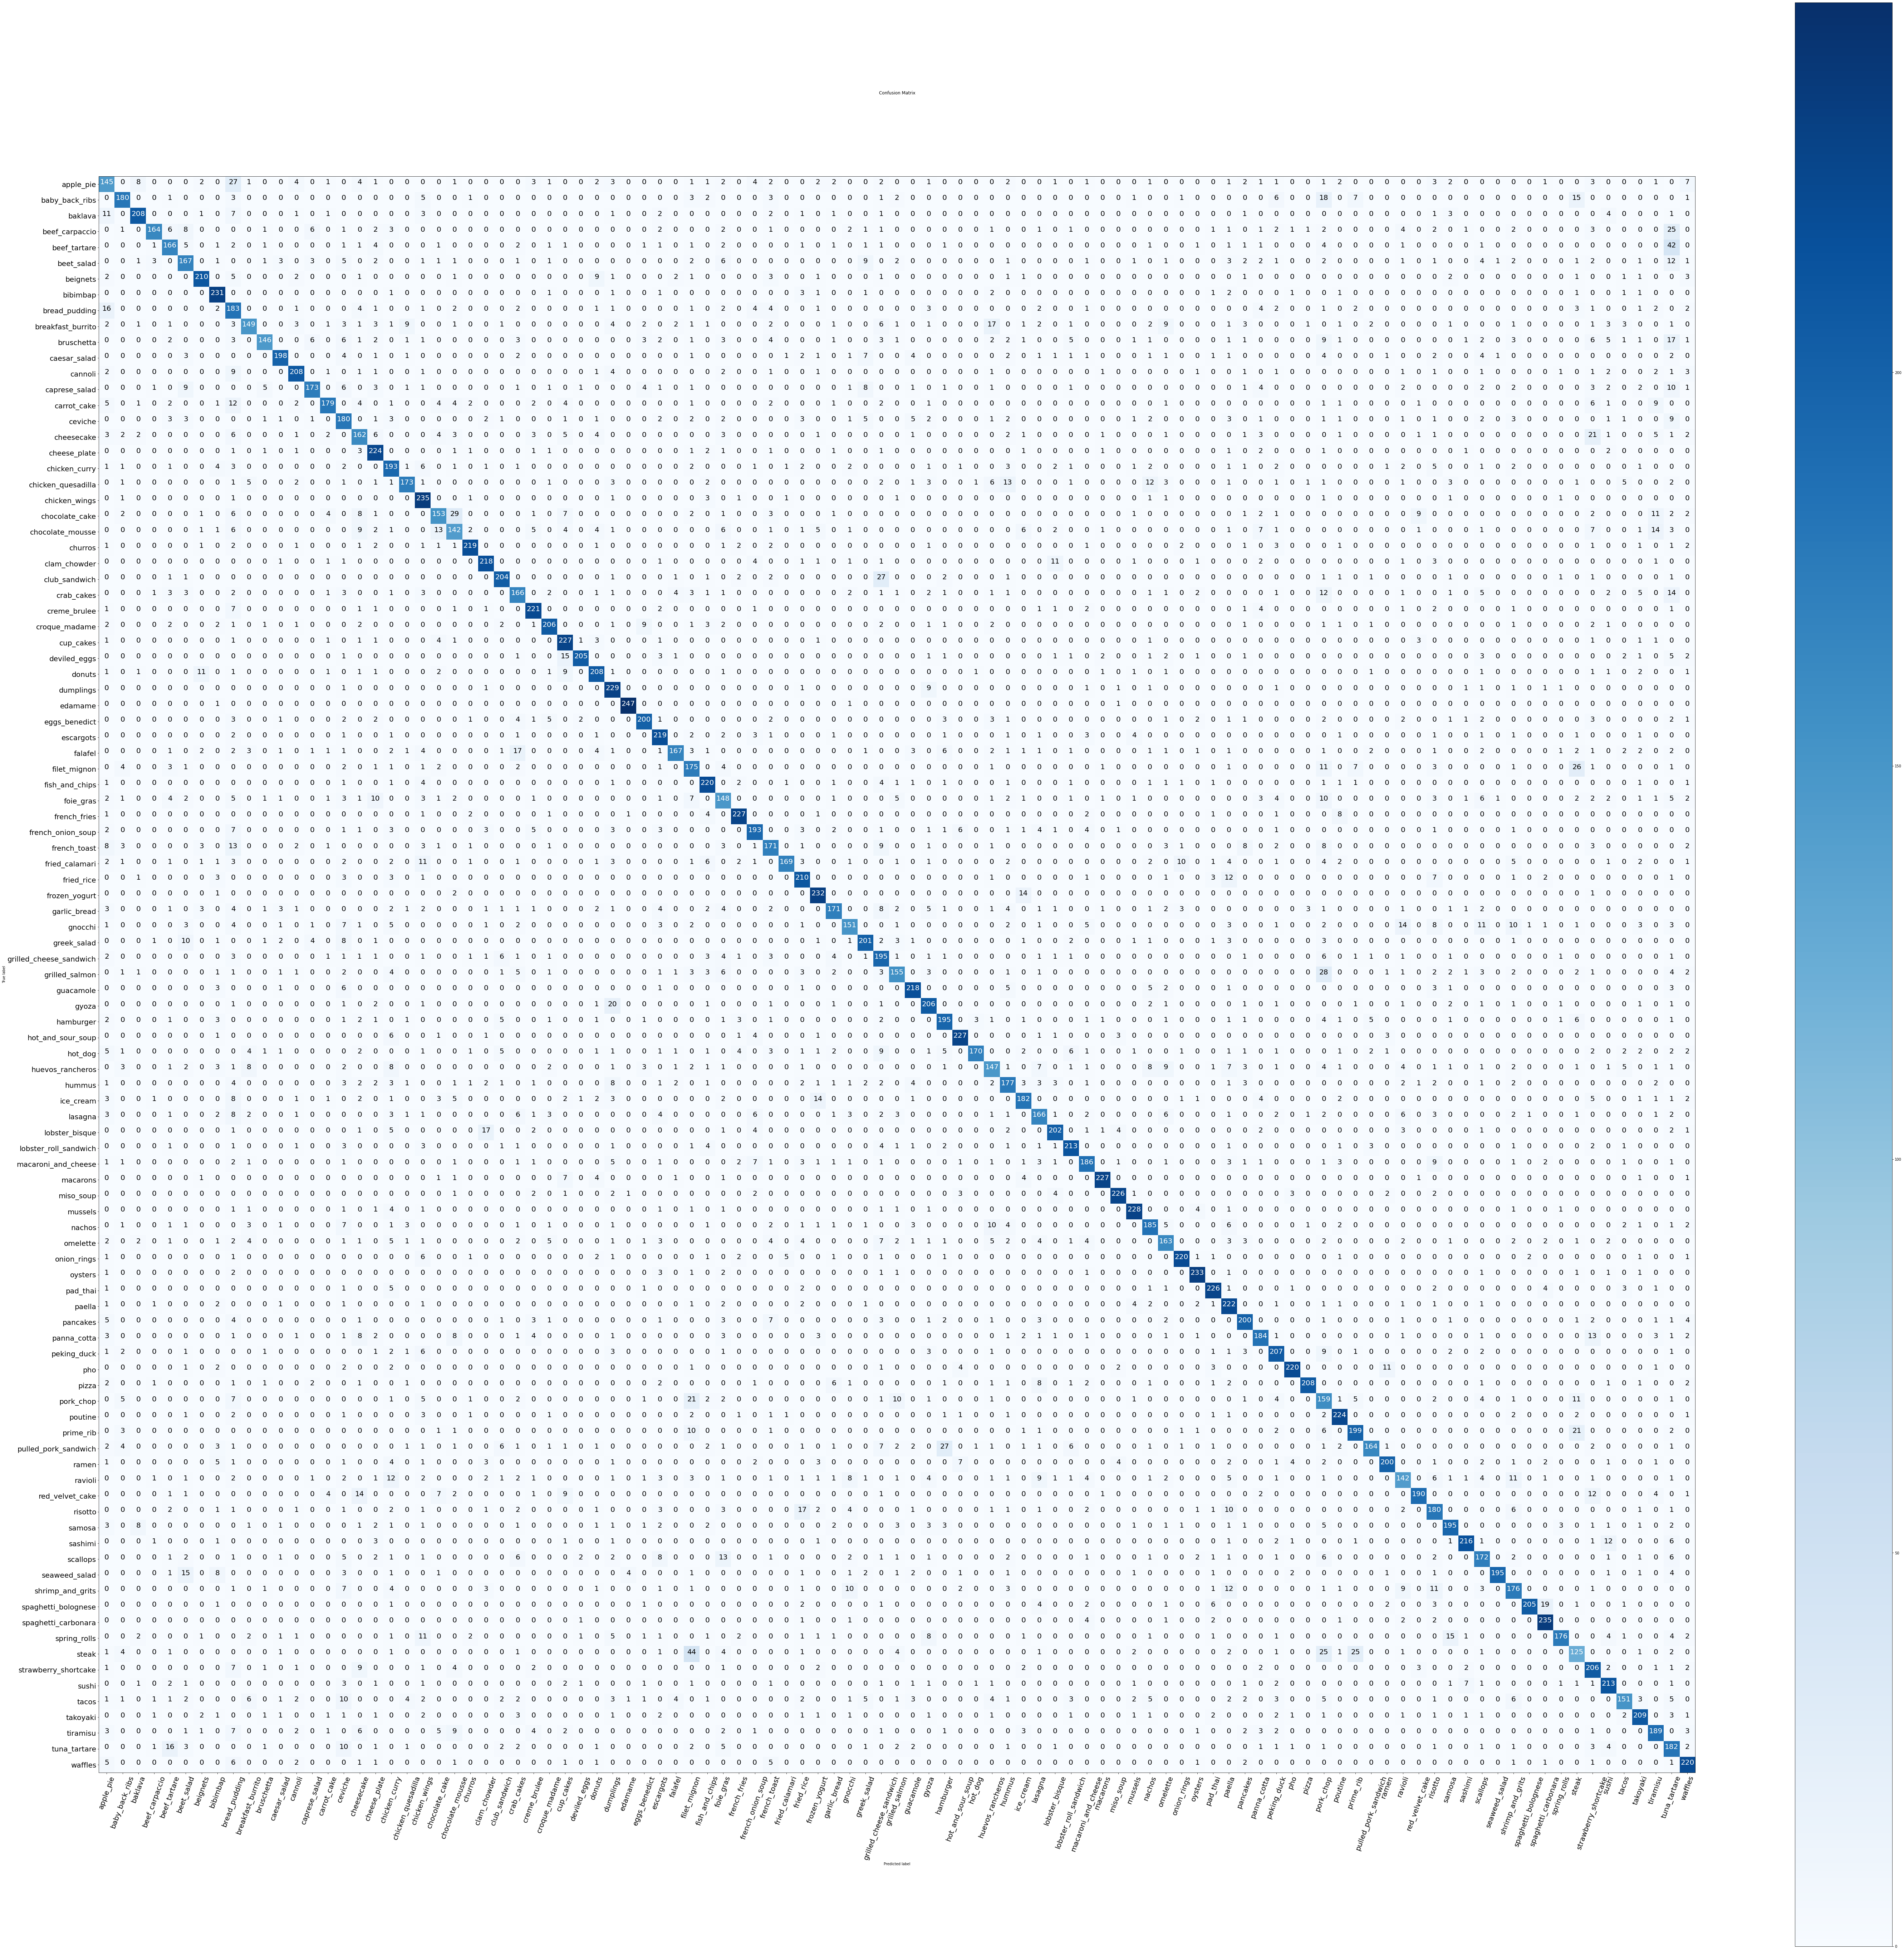

In [ ]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true, y_preds, classes=class_names, figsize=(100,100), text_size=20)

### Create a graph showing f1-score of all classes

In [ ]:
from sklearn.metrics import classification_report

sklearn_classficication_report = classification_report(y_true, y_preds, target_names= class_names)

print(sklearn_classficication_report)

                         precision    recall  f1-score   support

              apple_pie       0.55      0.58      0.56       250
         baby_back_ribs       0.81      0.72      0.76       250
                baklava       0.88      0.83      0.85       250
         beef_carpaccio       0.92      0.66      0.76       250
           beef_tartare       0.72      0.66      0.69       250
             beet_salad       0.68      0.67      0.67       250
               beignets       0.87      0.84      0.86       250
               bibimbap       0.80      0.92      0.86       250
          bread_pudding       0.44      0.73      0.55       250
      breakfast_burrito       0.78      0.60      0.68       250
             bruschetta       0.87      0.58      0.70       250
           caesar_salad       0.89      0.79      0.84       250
                cannoli       0.85      0.83      0.84       250
          caprese_salad       0.87      0.69      0.77       250
            carrot_cake 

In [ ]:
sklearn_classficication_report_dict = classification_report(y_true, y_preds, 
                                                       target_names= class_names,
                                                       output_dict=True)

In [ ]:
class_f1_scores = {}
for k, v in sklearn_classficication_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[k] = v['f1-score']
class_f1_scores

{'apple_pie': 0.5642023346303501,
 'baby_back_ribs': 0.7610993657505285,
 'baklava': 0.8542094455852156,
 'beef_carpaccio': 0.7645687645687645,
 'beef_tartare': 0.6931106471816284,
 'beet_salad': 0.6720321931589537,
 'beignets': 0.8553971486761711,
 'bibimbap': 0.8587360594795539,
 'bread_pudding': 0.5520361990950227,
 'breakfast_burrito': 0.6772727272727272,
 'bruschetta': 0.7002398081534771,
 'caesar_salad': 0.8372093023255814,
 'cannoli': 0.8421052631578947,
 'caprese_salad': 0.7723214285714285,
 'carrot_cake': 0.7885462555066078,
 'ceviche': 0.6271777003484321,
 'cheese_plate': 0.8205128205128205,
 'cheesecake': 0.6352941176470588,
 'chicken_curry': 0.6980108499095841,
 'chicken_quesadilla': 0.7637969094922736,
 'chicken_wings': 0.7925801011804384,
 'chocolate_cake': 0.6710526315789473,
 'chocolate_mousse': 0.5941422594142259,
 'churros': 0.8957055214723927,
 'clam_chowder': 0.858267716535433,
 'club_sandwich': 0.8309572301425661,
 'crab_cakes': 0.6680080482897385,
 'creme_brulee':

In [ ]:
# Turn f1-score into DataFrame for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()), "f1_score":list(class_f1_scores.values())}).sort_values("f1_score",ascending=False)

In [ ]:
f1_scores.head()

,class_names,f1_score
33,edamame,0.980159
63,macarons,0.926531
69,oysters,0.919132
64,miso_soup,0.916836
75,pho,0.907216


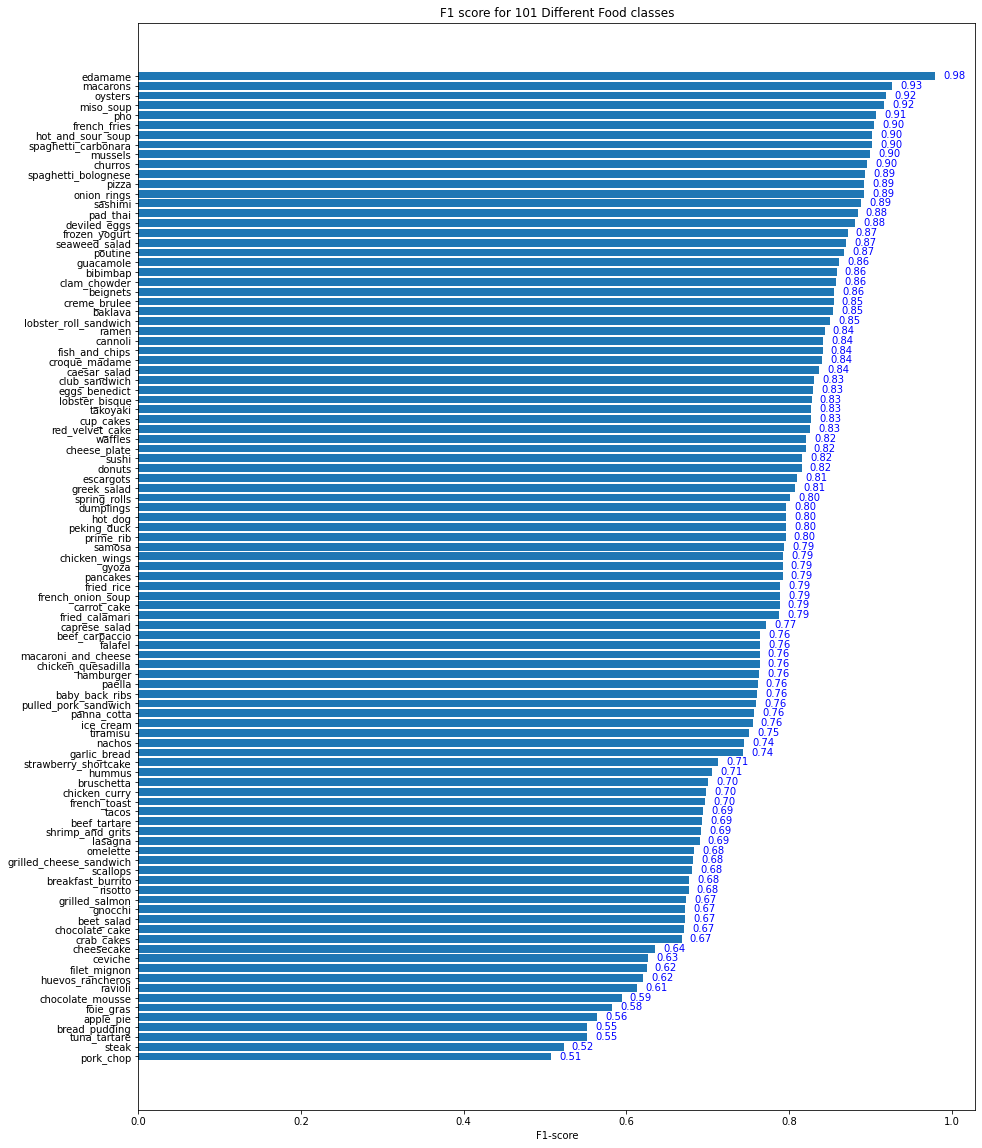

In [ ]:
import matplotlib.pyplot as plt

foods = list(f1_scores.class_names)
f1_score = list(f1_scores.f1_score)

fig, ax = plt.subplots(figsize=(15,20))
hbars = ax.barh(foods, f1_score)
# set number on top of the bar
# ax.bar_label(hbars, fmt="%.2f")
for i, v in enumerate(f1_score):
    ax.text(v + 0.01, i + .25, f"{v:.2f}", color='blue')

ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food classes")
ax.invert_yaxis()
plt.show()

### Visualize making predictions on random image

In [ ]:
# Map preprocessing function to testing and (parallelize) -> enable shuffling
test_data_optimized = test_data.map(map_func=preprocess_image,
                          num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
def plot_prediction(model, dataset, class_names):
  """
  predict and plot results

  Args:
    model (tensorflow model)
    dataset (tensorflow dataset)
    class_names (list of string)
  """
  plt.figure(figsize=(10,10))
  for image, labels in test_data_optimized.take(1):
    for i in range(9):
      img = image[i]
      true_label = labels[i]
      pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0))
      pred_class = pred_prob.argmax()
      color = "g" if true_label == pred_class else "r"
      title = f"{class_names[pred_class]}" if true_label == pred_class else f"{class_names[pred_class]}, true: {class_names[true_label]}"
      plt.subplot(3, 3, i+1)
      plt.imshow(img/255.)
      plt.axis(False)
      plt.title(title, color=color)
  plt.show()


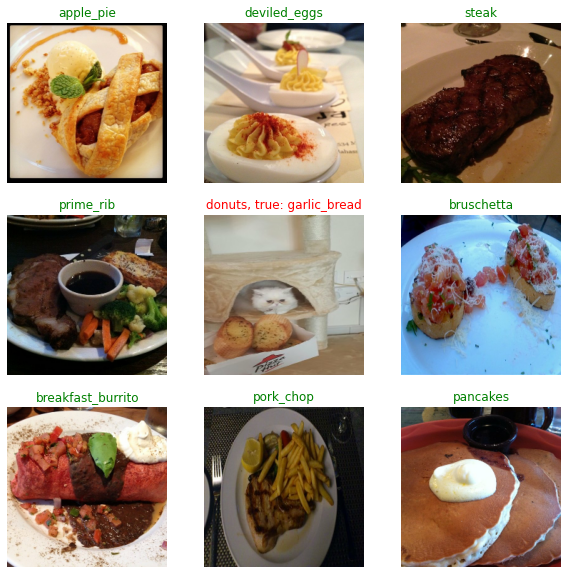

In [ ]:
plot_prediction(loaded_model, train_data_optimized, class_names)